# CS 410: Text Information Systems Course Project
# Demonstration Notebook
Python implementation of a causal topic modeling paper.

This program implements the following paper:
<blockquote>
    <p>Hyun Duk Kim, Malu Castellanos, Meichun Hsu, ChengXiang Zhai, Thomas Rietz, and Daniel Diermeier. 2013. Mining causal topics in text data: Iterative topic modeling with time series feedback. In Proceedings of the 22nd ACM international conference on information & knowledge management (CIKM 2013). ACM, New York, NY, USA, 885-890. DOI=10.1145/2505515.2505612</p>
</blockquote>

## Import Libraries

In [1]:
import numpy as np
import pandas as pd

## Import Data
### Time-Series: Iowa Electronic Markets (IEM)3 2000 Presidential Winner-Takes-All Market

In [2]:
pres_market = pd.read_csv("./data/PRES00_WTA.csv", skipinitialspace=True)
pres_market = pres_market.set_index("Date")
pres_market.index = pd.to_datetime(pres_market.index)
pres_market

,Contract,Units,$Volume,LowPrice,HighPrice,AvgPrice,LastPrice
Date,,,,,,,
2000-05-01,Dem,224,112.043,0.490,0.550,0.500,0.550
2000-05-01,Reform,2,0.067,0.019,0.048,0.034,0.019
2000-05-01,Rep,116,57.95,0.488,0.501,0.500,0.500
2000-05-02,Dem,87,44.369,0.501,0.522,0.510,0.508
2000-05-02,Reform,50,0.196,0.003,0.005,0.004,0.003
...,...,...,...,...,...,...,...
2000-11-09,Reform,"2,065",2.062,0.000,0.001,0.001,0.000
2000-11-09,Rep,"10,055",542.973,0.025,0.109,0.054,0.050
2000-11-10,Dem,"3,454","3,328.02",0.950,0.980,0.964,0.969


### Time-Series:  American Airlines Group Inc. (AAMRQ) and Apple Inc. (AAPL) Stock Closing Prices

In [3]:
AAMRQ = pd.read_csv("./data/AAMRQ.csv")
AAMRQ = AAMRQ.set_index("Date")
AAMRQ.index = pd.to_datetime(AAMRQ.index)
AAMRQ_close = AAMRQ["Close"]
AAMRQ_close

Date
2000-07-03    26.13
2000-07-05    28.38
2000-07-06    29.00
2000-07-07    29.13
2000-07-10    30.00
              ...  
2001-12-24    21.19
2001-12-26    21.57
2001-12-27    21.50
2001-12-28    22.00
2001-12-31    22.30
Name: Close, Length: 373, dtype: float64

In [4]:
AAPL = pd.read_csv("./data/AAPL.csv")
AAPL = AAPL.set_index("Date")
AAPL.index = pd.to_datetime(AAPL.index)
AAPL_close = AAPL["Close"]
AAPL_close

Date
2000-07-03    0.952009
2000-07-05    0.921875
2000-07-06    0.925223
2000-07-07    0.972098
2000-07-10    1.020089
                ...   
2001-12-21    0.375000
2001-12-24    0.381429
2001-12-26    0.383750
2001-12-27    0.394107
2001-12-28    0.400536
Name: Close, Length: 373, dtype: float64

### Text Corpus: New York Times Annotated Corpus (NYTAC)
Do not run this code below. It was to run the original data cleaning steps. Running again will delete the NYTAC in storage. It has been commented out for safety.

In [ ]:
"""
import os
import shutil
import tarfile
import xml.etree.ElementTree as ET

tars = []
for root, dirs, files in os.walk("./data/nyt_corpus/data"):
    if dirs:
        delete = dirs.copy()
        delete[:] = [x for x in dirs if x not in ['2000', '2001', '2002', '2003']]
        dirs[:] = [x for x in dirs if x in ['2000', '2001', '2002', '2003']]
        for name in delete:
            subdir = os.path.join(root, name)
            with os.scandir(subdir) as it:
                for entry in it:
                    os.remove(entry)
            os.rmdir(subdir)
    if files:
        if os.path.basename(root) == '2003':
            delete = files.copy()
            delete = [x for x in files if x not in ['01.tgz', '02.tgz', '03.tgz']]
            files[:] = [x for x in files if x in ['01.tgz', '02.tgz', '03.tgz']]
            for name in delete:
                os.remove(os.path.join(root, name))
        for file in files:
            tars.append(os.path.join(root, file))

for file_path in tars:
    tar = tarfile.open(file_path)
    tar.extractall(path=os.path.dirname(file_path))
    tar.close()
    os.remove(file_path)

# collect articles for 2000 Presidential Election
with os.scandir("./data/nyt_corpus/data/2000") as it:
    for entry in it:
        if os.path.basename(entry) in ['05', '06', '07', '08', '09', '10']:
            shutil.copytree(entry, os.path.join("./data/nyt_corpus/data/election/2000", os.path.basename(entry)))

# collect articles for Stock Time Series, AAMRQ vs. AAPL
with os.scandir("./data/nyt_corpus/data/2000") as it:
    for entry in it:
        if os.path.basename(entry) in ['07', '08', '09', '10', '11', '12']:
            shutil.copytree(entry, os.path.join("./data/nyt_corpus/data/stock/2000", os.path.basename(entry)))
with os.scandir("./data/nyt_corpus/data/2001") as it:
    for entry in it:
        shutil.copytree(entry, os.path.join("./data/nyt_corpus/data/stock/2001", os.path.basename(entry)))

# collect articles for Iraq War
with os.scandir("./data/nyt_corpus/data/2002") as it:
    for entry in it:
        shutil.copytree(entry, os.path.join("./data/nyt_corpus/data/war/2002", os.path.basename(entry)))
with os.scandir("./data/nyt_corpus/data/2003") as it:
    for entry in it:
        if os.path.basename(entry) in ['01', '02', '03']:
            shutil.copytree(entry, os.path.join("./data/nyt_corpus/data/war/2003", os.path.basename(entry)))

# remove unused directories
for year in ['2000', '2001', '2002', '2003']:
    shutil.rmtree(os.path.join("./data/nyt_corpus/data", os.path.basename(year)))

# initialize list of documents to delete
delete = []

# delete documents that do not contain "Bush" and "Gore" or do not contain document bodies
for root, dirs, files in os.walk("./data/nyt_corpus/data/election"):
    if files:
        for name in files:
            tree = ET.parse(os.path.join(root, name))
            tree_root = tree.getroot()
            element = tree_root.find('./body/body.content/block[@class="full_text"]')
            if element:
                keep = 0
                Bush = 0
                Gore = 0
                for para in element.findall('p'):
                    para_list = nltk.word_tokenize(para.text)
                    if 'Bush' in para_list:
                        Bush = 1
                    if 'Gore' in para_list:
                        Gore = 1
                    keep = Bush * Gore
                if not keep:
                    delete.append(os.path.join(root, name))
            else:
                delete.append(os.path.join(root, name))

# delete documents that do not contain document bodies
for root, dirs, files in os.walk("./data/nyt_corpus/data/stock"):
    if files:
        for name in files:
            tree = ET.parse(os.path.join(root, name))
            tree_root = tree.getroot()
            element = tree_root.find('./body/body.content/block[@class="full_text"]')
            if not element:
                delete.append(os.path.join(root, name))

# delete documents that do not contain "Iraq" or do not contain document bodies
for root, dirs, files in os.walk("./data/nyt_corpus/data/war"):
    if files:
        for name in files:
            tree = ET.parse(os.path.join(root, name))
            tree_root = tree.getroot()
            element = tree_root.find('./body/body.content/block[@class="full_text"]')
            if element:
                keep = 0
                for para in element.findall('p'):
                    para_list = nltk.word_tokenize(para.text)
                    if 'Iraq' in para_list:
                        keep = 1
                if not keep:
                    delete.append(os.path.join(root, name))
            else:
                delete.append(os.path.join(root, name))

# delete the unneeded documents
for name in delete:
    os.remove(name)

# delete empty directories
for root, dirs, files in os.walk("./data/nyt_corpus/data"):
    if not dirs and not files:
        os.rmdir(root)

# consolidate xml files into text files
# one text file contains the documents from the date in the file name
# documents are stored one document per line
for root, dirs, files in os.walk("./data/nyt_corpus/data"):
    if files:
        yyyy = os.path.basename(os.path.dirname(os.path.dirname(root)))
        mm = os.path.basename(os.path.dirname(root))
        dd = os.path.basename(root)
        file_name = yyyy + "-" + mm + "-" + dd + ".txt"
        base_folder = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(root))))
        directory = os.path.join("./data/nyt_corpus/data", base_folder)
        f = open(os.path.join(directory, file_name), "w")
        for name in files:
            tree = ET.parse(os.path.join(root, name))
            tree_root = tree.getroot()
            element = tree_root.find('./body/body.content/block[@class="full_text"]')
            paragraphs = []
            for para in element.findall('p'):
                paragraphs.append(para.text)
            f.write(" ".join(paragraphs) + "\n")
        f.close()

# remove unused directories
for subdir in ["election/2000", "stock/2000", "stock/2001", "war/2002", "war/2003"]:
    shutil.rmtree(os.path.join("./data/nyt_corpus/data", subdir))
"""

## Pre-Process Data
### Time-Series: Iowa Electronic Markets (IEM)3 2000 Presidential Winner-Takes-All Market
Follow standard practice in the field and use the “normalized” price of one candidate as a forecast probability of the election outcome:

(Gore price)/(Gore price + Bush price)

In [5]:
gore_price = pres_market.loc[pres_market["Contract"] == "Dem"]["AvgPrice"]
bush_price = pres_market.loc[pres_market["Contract"] == "Rep"]["AvgPrice"]
pres_market_forcprob = gore_price / (gore_price + bush_price)
pres_market_forcprob

Date
2000-05-01    0.500000
2000-05-02    0.507463
2000-05-03    0.508492
2000-05-04    0.510490
2000-05-05    0.519115
                ...   
2000-11-06    0.270378
2000-11-07    0.330986
2000-11-08    0.806452
2000-11-09    0.945838
2000-11-10    0.958250
Name: AvgPrice, Length: 192, dtype: float64

Make data series stationary.

In [6]:
pres_market_forcprob = pres_market_forcprob.rolling(3, center=True, min_periods=2).mean()
pres_market_forcprob = pres_market_forcprob.diff()[1:]
pres_market_forcprob

Date
2000-05-02    0.001587
2000-05-03    0.003497
2000-05-04    0.003884
2000-05-05    0.000984
2000-05-06    0.001596
                ...   
2000-11-06    0.029303
2000-11-07    0.179776
2000-11-08    0.225153
2000-11-09    0.209088
2000-11-10    0.048531
Name: AvgPrice, Length: 191, dtype: float64

### Time-Series:  American Airlines Group Inc. (AAMRQ) and Apple Inc. (AAPL) Stock Closing Prices
Make data series stationary.

In [7]:
AAMRQ_close = AAMRQ_close.rolling(3, center=True, min_periods=2).mean()
AAMRQ_close = AAMRQ_close.diff()[1:]
AAMRQ_close

Date
2000-07-05    0.581667
2000-07-06    1.000000
2000-07-07    0.540000
2000-07-10    0.146667
2000-07-11    0.500000
                ...   
2001-12-24   -0.026667
2001-12-26   -0.130000
2001-12-27    0.270000
2001-12-28    0.243333
2001-12-31    0.216667
Name: Close, Length: 372, dtype: float64

In [8]:
AAPL_close = AAPL_close.rolling(3, center=True, min_periods=2).mean()
AAPL_close = AAPL_close.diff()[1:]
AAPL_close

Date
2000-07-05   -0.003906
2000-07-06    0.006696
2000-07-07    0.032738
2000-07-10    0.030506
2000-07-11    0.026414
                ...   
2001-12-21   -0.001547
2001-12-24    0.004881
2001-12-26    0.006369
2001-12-27    0.006369
2001-12-28    0.004524
Name: Close, Length: 372, dtype: float64

## Use the Iterative Topic Modeling with Time Series Feedback (ITMF) Class
### Import Class from Module

In [40]:
from causal_topic_mining import ITMTF

### Run Algorithm

In [41]:
# Create object from ITMTF class
itmtf = ITMTF("./data/nyt_corpus/data/test", pres_market_forcprob)

# Tokenize text corpus and record document timestamps
itmtf.build_corpus()

# Build vocabulary
itmtf.build_vocabulary()

# Run ITMTF algorithm
itmtf.process(number_of_topics = 30, max_plsa_iter = 1, epsilon = 0.001, mu = 1000, itmtf_iter = 5)

ITMTF Loop:   0%|          | 0/5 [00:00<?, ?it/s]/home/ubuntu/CourseProject/causal_topic_mining.py:315: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pos_rows = len(wc[wc["Topic"] == topic][wc["Impact_Value"] >= 0])
/home/ubuntu/CourseProject/causal_topic_mining.py:316: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg_rows = len(wc[wc["Topic"] == topic][wc["Impact_Value"] < 0])

PLSA at end of ITMTF iter.: 100%|██████████| 5/5 [06:20<00:00, 76.18s/it]
/home/ubuntu/CourseProject/causal_topic_mining.py:383: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pos_rows = len(wc[wc["Topic"] == topic][wc["Impact_Value"] >= 0])
/home/ubuntu/CourseProject/causal_topic_mining.py:384: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  neg_rows = len(wc[wc["Topic"] == topic][wc["Impact_Value"] < 0])
ITMTF Loop:  20%|██        | 1/5 [08:00<32:01, 480.33s/it]/home/ubuntu/CourseProje

### Plot Results

In [42]:
import matplotlib.pyplot as plt

In [49]:
itmtf.average_topic_purity

[52.117826601353954, 45.46477444148896, 40.511062510978824, nan, nan]

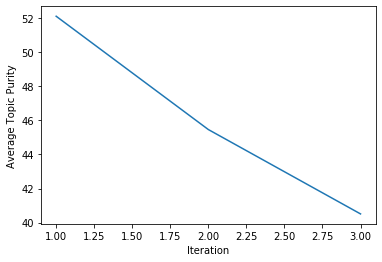

In [44]:
plt.plot(range(1, len(itmtf.average_topic_purity) + 1), itmtf.average_topic_purity)
plt.xlabel("Iteration")
plt.ylabel("Average Topic Purity")
plt.show()

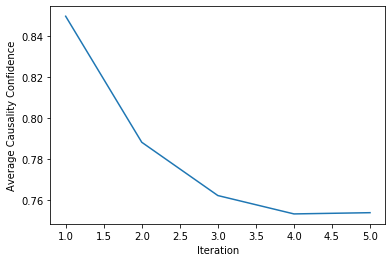

In [45]:
plt.plot(range(1, len(itmtf.average_causality_confidence) + 1),itmtf.average_causality_confidence)
plt.xlabel("Iteration")
plt.ylabel("Average Causality Confidence")
plt.show()

### Top Three Words per Topic
Each line is a topic and left most word is highest probability.

In [50]:
for topic in itmtf.topic_word_prob:
    out = ""
    for word in topic.argsort()[-3:][::-1]:
        out += " "
        out += itmtf.vocabulary[word]
    print(out)

 bush say gore
 bush campaign vice
 tax gore would
 bush campaign billion
 uninsured say gore
 state president letter
 gore bush debate
 say campaign bush
 say gore campaign
 bush gore state
 gore say al
 clinton say candidate
 court abortion right
 say black people
 oil price say
 go get people
 republican say democrat
 say clinton gore
 say like people
 clinton say radio
 say bush gore
 gore debate say
 american military say
 republican lieberman cheney
 drug health medical
 say voter vote
 debt surplus budget
 new a one say
 debate say bush
 campaign say money
